### Import the Libraries, Data and Have a Look at the Data!

In [335]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import regularizers
import warnings
from imblearn.under_sampling import RandomUnderSampler
import os
# import smote package
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, SMOTENC

In [336]:
train_df = pd.read_csv(r"data\train.csv")
test_df = pd.read_csv(r"data\test.csv")

In [337]:
### stripping the space from the column names

train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

### Data Cleaning

The following columns have been dropped: {'EL', 'BQ'} and the remaining missing data is filled using median/mode.
The Shape of the train_df is: (617, 56)


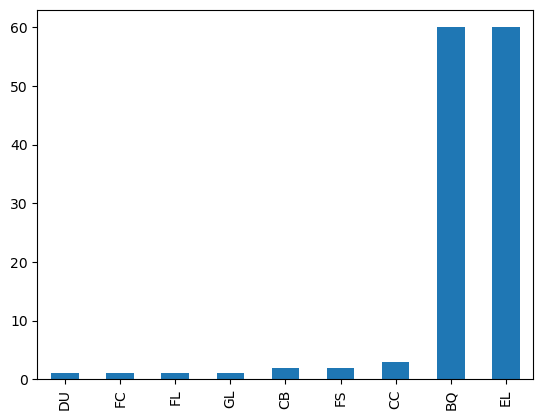

In [338]:
def missing_values(df):
    """ This function takes a dataframe as input and returns a dataframe with missing values filled with median/mode and a list of dropped columns. Also, it plots the missing values in a bar chart."""

    ### Plotting missing values
    missing_vals = df.isnull().sum()
    missing_vals = missing_vals[missing_vals > 0]
    missing_vals.sort_values(inplace=True)
    missing_vals.plot.bar()

    data_filtered = df.dropna(thresh=len(df) * (1-.05), axis=1).copy()
    dropped_columns = set(df.columns.tolist()) - set(data_filtered.columns.tolist())

    # Fill missing numeric values with median
    numeric_features = data_filtered.select_dtypes(include=[np.number])
    for col in numeric_features.columns:
        if data_filtered[col].isnull().any():
            data_filtered.loc[:, col] = data_filtered[col].fillna(data_filtered[col].median())

    # Fill missing categorical values with mode
    categorical_features = data_filtered.select_dtypes(exclude=[np.number])
    for col in categorical_features.columns:
        if data_filtered[col].isnull().any():
            data_filtered.loc[:, col] = data_filtered[col].fillna(data_filtered[col].mode()[0])

    # Check for missing values and report how many columns have been dropped
    print(f"The following columns have been dropped: {dropped_columns} and the remaining missing data is filled using median/mode.")

    return data_filtered, dropped_columns

# Call the function
train_df, dropped_columns = missing_values(train_df)
print(f"The Shape of the train_df is: {train_df.shape}")

### Data Exploration

In [339]:
### splitting the data into numerical and categorical features and target
train_target = train_df['Class']
train_cat_features = train_df['EJ']
train_num_features = train_df.drop(['Id', 'Class', 'EJ'], axis=1)

### Standardizing the numerical features
num_cols = train_num_features.columns.tolist()
scaler = StandardScaler()
train_num_features = scaler.fit_transform(train_num_features)
train_num_features = pd.DataFrame(train_num_features, columns=num_cols)

### One-hot encoding the categorical features
train_cat_features = train_cat_features.map({'A': 0, 'B': 1})

### Concatenating the numerical and categorical features
train_features = pd.concat([train_num_features, train_cat_features], axis=1)

### Concatenating the features and target
train_data = pd.concat([train_features, train_target], axis=1)

### Dealing with Outliers

In [340]:
### stopping the warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import IsolationForest

def run_isolation_forest(df, contamination=0.025, max_features=2):
    # Fit the model
    isof = IsolationForest(random_state=42, contamination=contamination, max_features=max_features).fit(df)
    results = isof.predict(df)
    df['isolation scores'] = results
    df['is_outlier'] = np.where(df['isolation scores'] == -1, 1, 0)
    print(f"{len(df[df['is_outlier'] == 1])} Outliers Detected")
    df = df.drop(['isolation scores'], axis=1)
    
    return df


In [341]:
%% script false
### Running the isolation forest
### Specify the contamination and max_features
contamination = 0.025

train_data = run_isolation_forest(train_data, contamination=contamination, max_features=10)

### Plotting the outliers
sns.pairplot(train_data[["is_outlier", "AB", 'AH', 'AM', 'CL', 'CR', 'CS']], hue="is_outlier")
plt.show()

### Dropping the outliers
train_data = train_data[train_data['is_outlier'] == 0]
train_data = train_data.drop(['is_outlier'], axis=1)
print(f"Shape of the dataframe after dropping outliers: {train_data.shape}")

UsageError: Cell magic `%%` not found.


In [342]:
%% script false

# Get all the columns
columns = train_data.columns.tolist()

# Calculate the number of rows needed for subplots
n = len(columns)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

# Create a figure and axes for subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 4*nrows))  # Adjust as per your requirement
axs = axs.flatten()  # to make it easier to iterate over

# For each column and its corresponding subplot, create a boxplot
for ax, col in zip(axs, columns):
    sns.boxplot(data=train_data, x='Class', y=col, ax=ax)
    ax.set_title(f'Class vs {col}')

# If there are less columns than subplots, remove the extra ones
for i in range(n, nrows*ncols):
    fig.delaxes(axs[i])

# Show the plot
plt.tight_layout()
plt.show()

UsageError: Cell magic `%%` not found.


After data visualization, here are some takeaways:
1. There are no strong relations of any variable with the output. So, it would be difficult to correctly classify output, especially when there is so small dataset.
2. There are many outliers in the dataset that do no follow the general patterns of the data. So, we are going to cap the data to 0.05 and 0.95 percentile.

### Data Pre-processing

In [343]:
### Winsorizing the data
import pandas as pd

def winsorize_df(df):
    for col in df.columns:
        if df[col].dtype.kind in 'biufc':
            lower = df[col].quantile(0.01)
            upper = df[col].quantile(0.95)
            df[col] = df[col].clip(lower, upper)
    return df

train_data_capped = train_data.copy()
train_features_capped = winsorize_df(train_data_capped.drop(['Class'], axis=1))


#### Handling Data Imbalance
1. Undersampling -> Loss of information
 * Randomundersampling drops random data which might deviate our data from the actual distribution and lose some potential, diverse data points
2. Oversamping -> Oversampling uses the minority class and artificically produces data points to make them equal in number to majority class.
 * Oversampling can cause overfitting for minority class since we are passing same examples again and again.
 * Oversample can be done using duplication using replacement and also SMOTE(synthetically producing some data points close to original data)
3. Class Weighting
 * Give more weight to minority class.
4. Altering the loss function to penalize the majority class more. 

In [482]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
#   Split the data into train and test sets
validation_size = 0.2
random_state = 92
y = train_data['Class']
X = train_data.drop(['Class'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size, shuffle=True, random_state=random_state, stratify=y)

# Apply ADASYN
sm = ADASYN(random_state=random_state)
X_train, y_train = sm.fit_resample(X_train, y_train)

Notes = 'applied top 20 features using selectKBest and then applied ADASYN'

### Data Modeling

In [346]:
### Setting random states for reproducibility
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [347]:
def update_performance(df_metrics, file='performance_tracking.csv'):
    if os.path.isfile(file):   # if file exists
        df_stored = pd.read_csv(file)
        df_updated = pd.concat([df_stored, df_metrics], ignore_index=True, axis = 0)
        df_updated.drop_duplicates(inplace=True)
    else:   # if file does not exist
        df_updated = df_metrics
    df_updated.to_csv(file, index=False)
    return df_updated

### Lazy Classifier

In [401]:
# Applying LazyClassifier
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)

models, predictions = clf.fit(X_train, X_val, y_train, y_val)

models

100%|██████████| 29/29 [00:02<00:00, 12.55it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.92,0.86,0.86,0.92,0.18
LinearDiscriminantAnalysis,0.84,0.85,0.85,0.85,0.02
RidgeClassifierCV,0.84,0.85,0.85,0.85,0.02
RidgeClassifier,0.84,0.85,0.85,0.85,0.02
RandomForestClassifier,0.89,0.84,0.84,0.89,0.42
LGBMClassifier,0.88,0.84,0.84,0.88,0.13
BernoulliNB,0.83,0.83,0.83,0.84,0.02
XGBClassifier,0.89,0.82,0.82,0.89,0.10
NearestCentroid,0.82,0.82,0.82,0.84,0.01


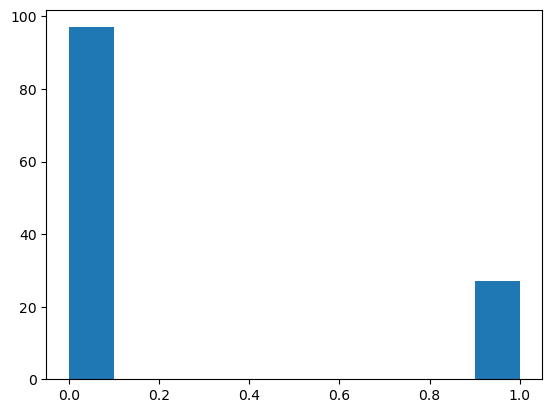

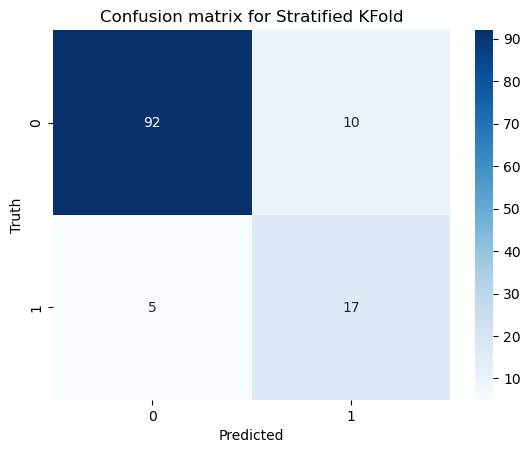

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       102
           1       0.63      0.77      0.69        22

    accuracy                           0.88       124
   macro avg       0.79      0.84      0.81       124
weighted avg       0.89      0.88      0.88       124



In [383]:
y_pred=predictions.LGBMClassifier

# Plot the predicted probabilities histogram
plt.hist(y_pred, bins=10)
plt.show()
y_pred = np.where(y_pred > 0.5, 1, 0)

### Plotting a confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion matrix for Stratified KFold')
plt.show()

### Printing the classification report
print(classification_report(y_val, y_pred))

### LGBM

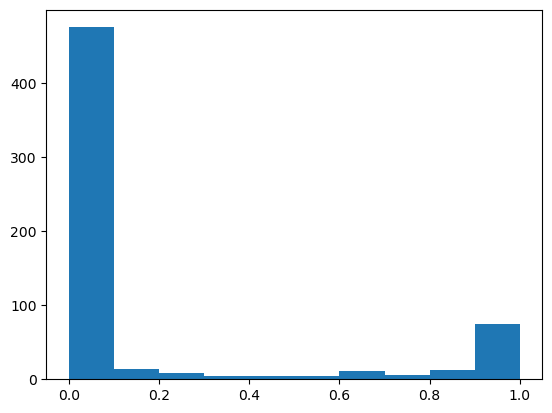

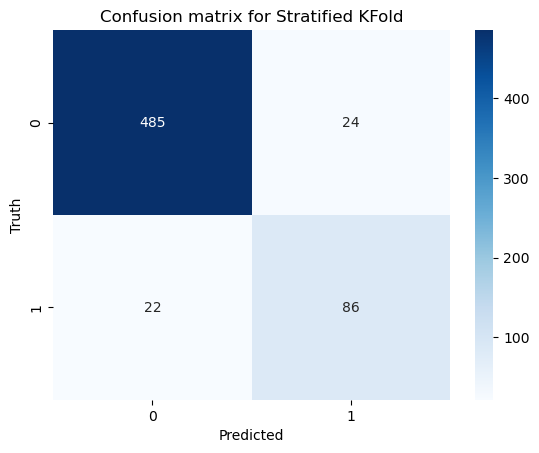

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       509
           1       0.78      0.80      0.79       108

    accuracy                           0.93       617
   macro avg       0.87      0.87      0.87       617
weighted avg       0.93      0.93      0.93       617



In [384]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from lightgbm import LGBMClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state+1)

probs = np.zeros(len(y))
preds = np.zeros(len(y))

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    sm = ADASYN(random_state=random_state)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    # Create and fit the XGBoost model
    # Create the model
    model = LGBMClassifier()

    model.fit(X_train, y_train)

    # Predict on the test set
    probs[test_index] = model.predict_proba(X_test)[:, 1]

# Plot the predicted probabilities histogram
plt.hist(probs, bins=10)
plt.show()
probs = np.where(probs > 0.5, 1, 0)

### Plotting a confusion matrix
cm = confusion_matrix(y, probs)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion matrix for Stratified KFold')
plt.show()

### Printing the classification report
print(classification_report(y, probs))

### XGBoost

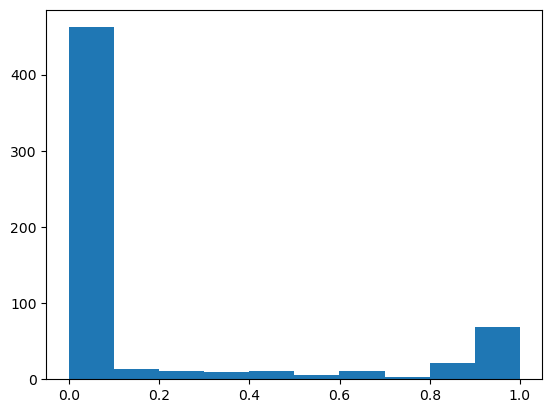

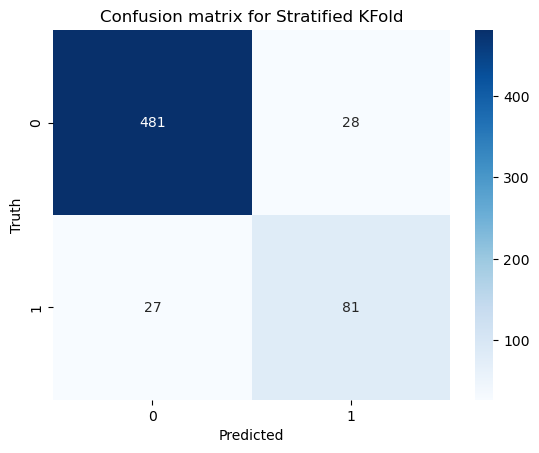

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       509
           1       0.74      0.75      0.75       108

    accuracy                           0.91       617
   macro avg       0.84      0.85      0.85       617
weighted avg       0.91      0.91      0.91       617



In [349]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state+1)

probs = np.zeros(len(y))
preds = np.zeros(len(y))

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    sm = ADASYN(random_state=random_state)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    # Create and fit the XGBoost model
    model = xgb.XGBClassifier(use_label_encoder=False)
    model.fit(X_train, y_train)

    # Predict on the test set
    probs[test_index] = model.predict_proba(X_test)[:, 1]

# Plot the predicted probabilities histogram
plt.hist(probs, bins=10)
plt.show()
probs = np.where(probs > 0.5, 1, 0)

### Plotting a confusion matrix
cm = confusion_matrix(y, probs)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion matrix for Stratified KFold')
plt.show()

### Printing the classification report
print(classification_report(y, probs))

In [350]:
%% script false
xgb_cr = classification_report(y_val, y_pred, output_dict=True)

### Getting the scores for the minority class
precision = xgb_cr['1']['precision']
recall =  xgb_cr['1']['recall']
f1_score = xgb_cr['1']['f1-score']
accuracy = xgb_cr['accuracy']

xgb_metrics = pd.DataFrame({
    'model': [history.__class__.__name__],
    'random_state': [random_state],
    'validation_split': [validation_size],
    'contamination': [contamination],
    'accuracy' : round(accuracy, 2),
    'precision': round(precision, 2),
    'recall': round(recall, 2),
    'f1_score': round(f1_score, 2),
    'Notes': Notes
})

performance_updated = update_performance(xgb_metrics)

### showing last 5 rows of the performance tracking dataframe
performance_updated.tail()


UsageError: Cell magic `%%` not found.


### Random Forest

After applying Gradient Boosing Classifier, Random Forest Classifier and Ada Boost Classifier, it was found that Random Forest outperformed other trees and thus, only RFs predictions are shown here.

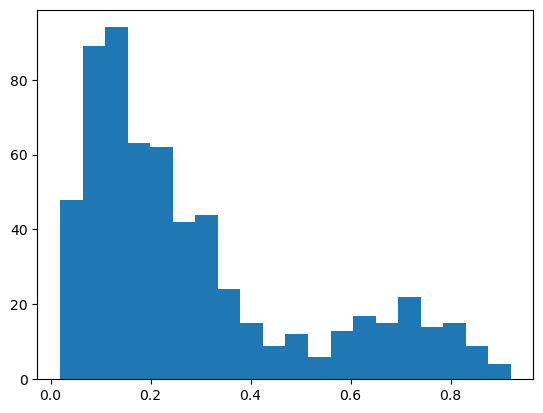

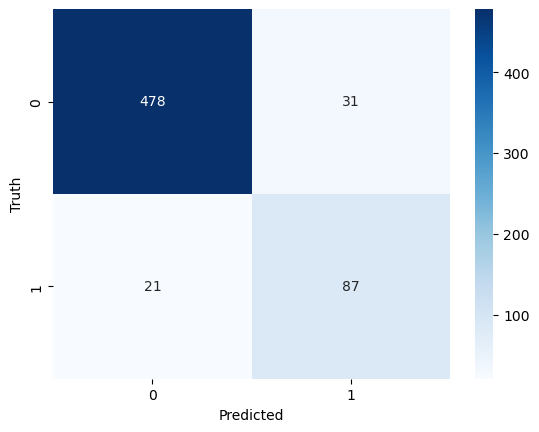

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       509
           1       0.74      0.81      0.77       108

    accuracy                           0.92       617
   macro avg       0.85      0.87      0.86       617
weighted avg       0.92      0.92      0.92       617



In [485]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = random_state)

probs = np.zeros(len(y))
preds = np.zeros(len(y))

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    sm = SMOTE(random_state=82)
    X_train_fold, y_train_fold = sm.fit_resample(X_train_fold, y_train_fold)

    # Create a Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=200, random_state=random_state, max_depth=5, min_samples_split=8, min_samples_leaf=4, n_jobs=-1, criterion='log_loss', bootstrap=False)

    rf.fit(X_train_fold, y_train_fold)

    # Predict on the test set
    probs[test_index] = rf.predict_proba(X_test_fold)[:, 1]


# plot the distribution of probabilities
plt.hist(probs, bins=20)
plt.show()

# Use a threshold of 0.5 to create labels
probs = np.where(probs > 0.5, 1, 0)

### Plotting a confusion matrix
cm = confusion_matrix(y, probs)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Printing the classification report
print(classification_report(y, probs))

In [486]:
# Saving the performance metrics
rf_cr = classification_report(y_val, y_pred, output_dict=True)

### Getting the scores for the minority class
precision = rf_cr['1']['precision']
recall =  rf_cr['1']['recall']
f1_score = rf_cr['1']['f1-score']
accuracy = rf_cr['accuracy']

xgb_metrics = pd.DataFrame({
    'model': [rf_history.__class__.__name__],
    'random_state': [random_state],
    'validation_split': [validation_size],
    'contamination': [contamination],
    'accuracy' : round(accuracy, 2),
    'precision': round(precision, 2),
    'recall': round(recall, 2),
    'f1_score': round(f1_score, 2),
    'Notes': Notes
})

performance_updated = update_performance(xgb_metrics)

### showing last 5 rows of the performance tracking dataframe
performance_updated.tail()


,model,random_state,validation_split,accuracy,precision,recall,f1_score,Notes,contamination
84,XGBClassifier,3.00,0.15,0.92,0.67,0.92,0.77,applied top 20 features using selectKBest and ...,0.05
85,RandomForestClassifier,3.00,0.15,0.90,0.60,0.92,0.73,applied top 20 features using selectKBest and ...,0.05
86,XGBClassifier,3.00,0.15,0.96,0.83,0.94,0.88,applied top 20 features using selectKBest and ...,0.05
87,RandomForestClassifier,3.00,0.15,0.91,0.67,1.00,0.80,applied top 20 features using selectKBest and ...,0.05
88,RandomForestClassifier,92.00,0.20,0.85,0.55,0.77,0.64,applied top 20 features using selectKBest and ...,0.03


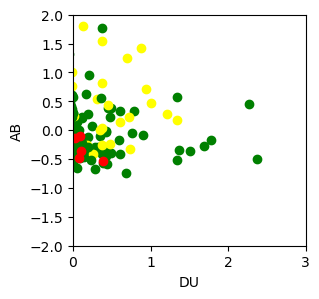

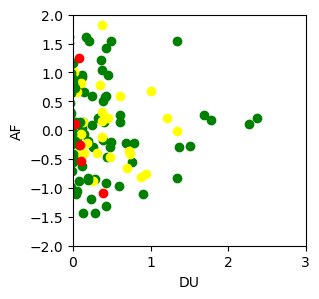

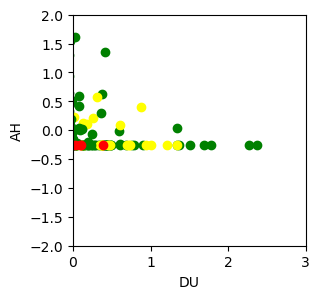

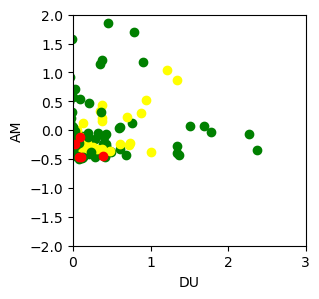

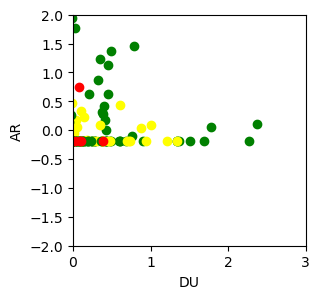

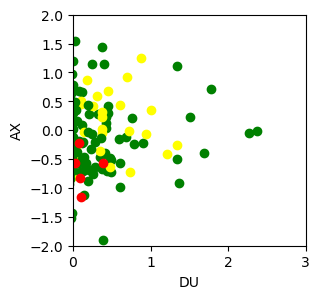

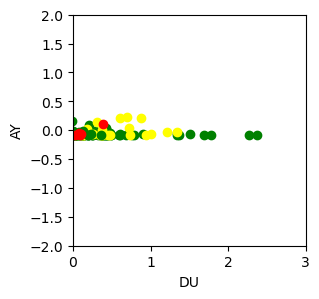

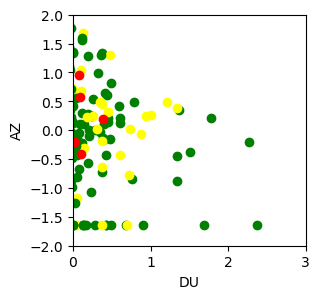

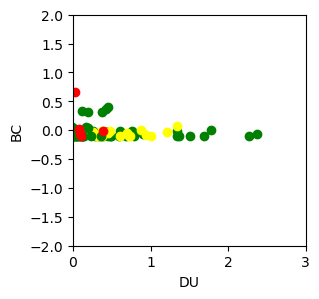

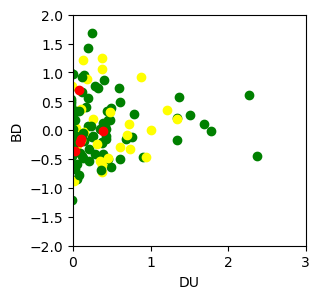

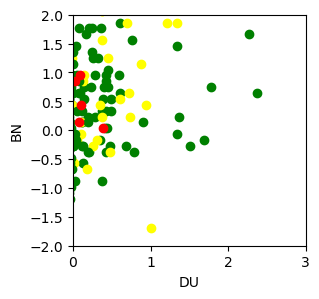

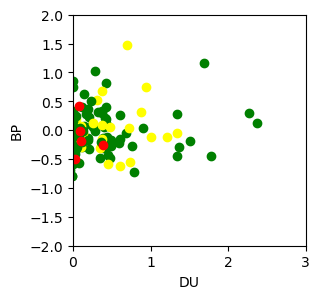

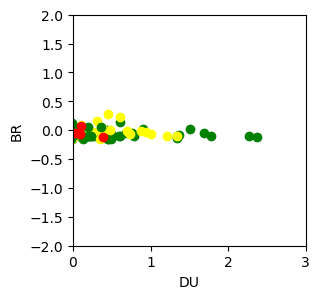

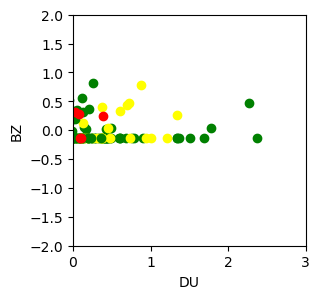

In [492]:
### Creating a scatter plot of the positive predictions and giving true positives and false negatives different colors
columns = X_test.columns

y_pred = probs

for col in columns[:-40]:
    column1 = 'DU'
    column2 = col

    plt.figure(figsize=(3, 3))
    plt.scatter(X[(y_pred == 1) & (y == 1)][column1], X[(y_pred == 1) & (y == 1)][column2], color='green', label='True Positives')
    plt.scatter(X[(y_pred == 1) & (y == 0)][column1], X[(y_pred == 1) & (y == 0)][column2], color='yellow', label='False Positives')
    plt.scatter(X[(y_pred == 0) & (y == 0)][column1], X[(y_pred == 0) & (y == 0)][column2], color='green', label='True Negatives')
    plt.scatter(X[(y_pred == 0) & (y == 1)][column1], X[(y_pred == 0) & (y == 1)][column2], color='red', label='False Negatives')
    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.xlim([0, 3])
    plt.ylim([-2, 2])
    #plt.legend()
    plt.show()

array(['DU', 'FL', 'CR', 'AB', 'BC', 'AF', 'GL', 'EB', 'EH', 'DH', 'FD',
       'DA', 'DI', 'BN', 'DF', 'FR', 'EU', 'DL', 'EE', 'CD'], dtype=object)

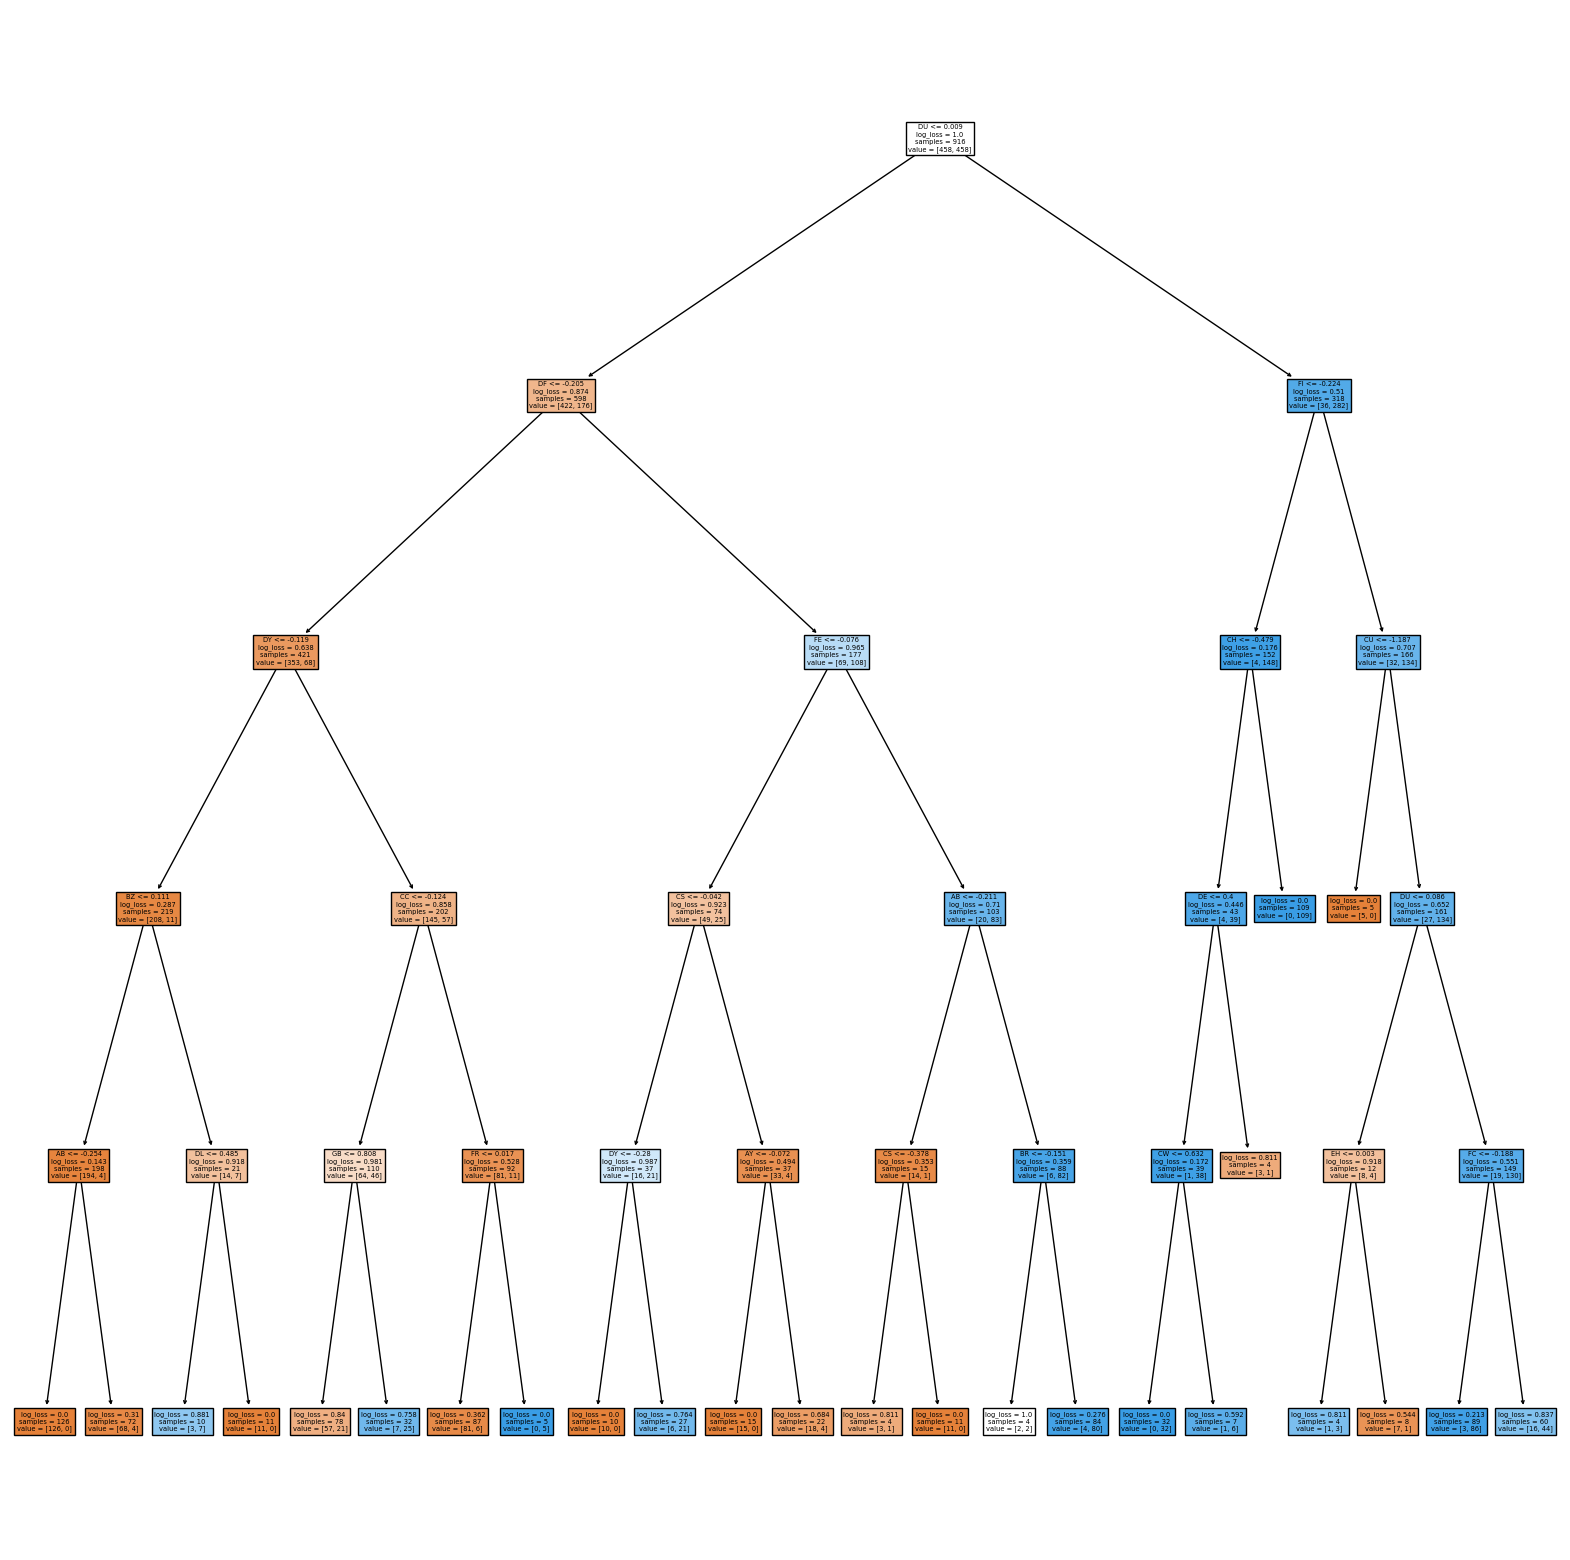

In [484]:
### Printing the feature importance of 10 most important features
feature_importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending=False)
#### Saving the top 10 features
top_20_features = feature_importances.iloc[:20, :]['feature'].values
display(top_20_features)

# Visualizing the decision tree
from sklearn import tree
plt.figure(figsize=(20, 20))
tree.plot_tree(rf.estimators_[6], feature_names=X.columns, filled=True)
plt.show()


In [355]:
raise Exception("Stop!")

Exception: Stop!

### MLP Neural Network

In [494]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state+1)

probs = np.zeros(len(y))
preds = np.zeros(len(y))

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    sm = ADASYN(random_state=random_state)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    # Create a Sequential model
    model = Sequential()

    # Add regularization (l2) to the layers
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
    model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    # Use sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Add gradient clipping to Adam optimizer
    adam = Adam(learning_rate=.0001, clipvalue=0.5)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['BinaryAccuracy'])

    # Add early stopping to prevent overfitting
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=5, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

    # Predict on the test set
    probs[test_index] = model.predict(X_test).reshape(len(X_test))

# Plot the predicted probabilities histogram
plt.hist(probs, bins=10)
plt.show()
probs = np.where(probs > 0.5, 1, 0)

### Plotting a confusion matrix
cm = confusion_matrix(y, probs)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion matrix for Stratified KFold')
plt.show()

### Printing the classification report
print(classification_report(y, probs))

Epoch 1/50
164/164 [==============================] - 1s 3ms/step - loss: 14.3606 - binary_accuracy: 0.6276 - val_loss: 11.6619 - val_binary_accuracy: 0.7339
Epoch 2/50
164/164 [==============================] - 0s 2ms/step - loss: 9.6270 - binary_accuracy: 0.8010 - val_loss: 7.8287 - val_binary_accuracy: 0.7258
Epoch 3/50
164/164 [==============================] - 0s 2ms/step - loss: 6.4762 - binary_accuracy: 0.8535 - val_loss: 5.2953 - val_binary_accuracy: 0.7419
Epoch 4/50
164/164 [==============================] - 0s 2ms/step - loss: 4.3918 - binary_accuracy: 0.8645 - val_loss: 3.6691 - val_binary_accuracy: 0.7500
Epoch 5/50
164/164 [==============================] - 0s 2ms/step - loss: 3.0240 - binary_accuracy: 0.8877 - val_loss: 2.5766 - val_binary_accuracy: 0.8306
Epoch 6/50
164/164 [==============================] - 0s 2ms/step - loss: 2.1717 - binary_accuracy: 0.9023 - val_loss: 1.9899 - val_binary_accuracy: 0.7984
Epoch 7/50
164/164 [==============================] - 0s 2ms/s

KeyboardInterrupt: 

In [396]:
%% script false
### Creating a MLP neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow import keras


# Create a Sequential model
model = Sequential()

# Add regularization (l2) to the layers
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Use sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Add gradient clipping to Adam optimizer
adam = Adam(learning_rate=.0001, clipvalue=0.5)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Add early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=5, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/100
162/162 [==============================] - 1s 3ms/step - loss: 18.4964 - accuracy: 0.6708 - val_loss: 14.9412 - val_accuracy: 0.8629
Epoch 2/100
162/162 [==============================] - 0s 1ms/step - loss: 12.2728 - accuracy: 0.7871 - val_loss: 9.9039 - val_accuracy: 0.8226
Epoch 3/100
162/162 [==============================] - 0s 1ms/step - loss: 8.1346 - accuracy: 0.8379 - val_loss: 6.6017 - val_accuracy: 0.8387
Epoch 4/100
162/162 [==============================] - 0s 1ms/step - loss: 5.4297 - accuracy: 0.8800 - val_loss: 4.4682 - val_accuracy: 0.8629
Epoch 5/100
162/162 [==============================] - 0s 1ms/step - loss: 3.7036 - accuracy: 0.9270 - val_loss: 3.1689 - val_accuracy: 0.8629
Epoch 6/100
162/162 [==============================] - 0s 1ms/step - loss: 2.6189 - accuracy: 0.9443 - val_loss: 2.4048 - val_accuracy: 0.8387
Epoch 7/100
162/162 [==============================] - 0s 1ms/step - loss: 1.9399 - accuracy: 0.9468 - val_loss: 1.8378 - val_accuracy: 0.8

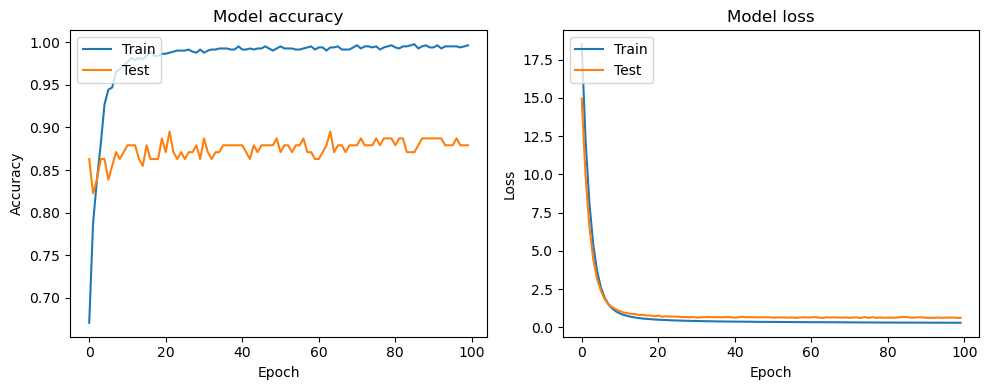

In [397]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

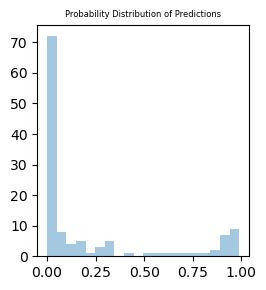

In [398]:
# Predicting the test set results
y_pred = model.predict(X_val)

# Plotting the probability distribution of the predictions
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
sns.distplot(y_pred, bins=20, kde=False)
plt.title('Probability Distribution of Predictions', size=6)
plt.show()

y_pred = (y_pred > 0.5)

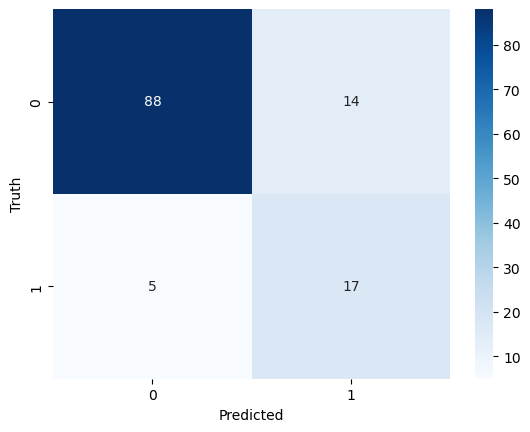

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       102
           1       0.55      0.77      0.64        22

    accuracy                           0.85       124
   macro avg       0.75      0.82      0.77       124
weighted avg       0.88      0.85      0.86       124



In [399]:
### Plotting a confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Getting the precision and recall scores
print(classification_report(y_val, y_pred))

In [ ]:
nn_cr = classification_report(y_val, y_pred, output_dict=True)

### Getting the scores for the minority class
precision = nn_cr['1']['precision']
recall =  nn_cr['1']['recall']
f1_score = nn_cr['1']['f1-score']
accuracy = nn_cr['accuracy']

nn_metrics = pd.DataFrame({
    'model': [model.__class__.__name__],
    'random_state': [np.NaN],
    'validation_split': [validation_size],
    'accuracy' : round(accuracy, 2),
    'precision': round(precision, 2),
    'recall': round(recall, 2),
    'f1_score': round(f1_score, 2),
    'Notes': Notes
})

performance_updated = update_performance(nn_metrics)

### showing last 5 rows of the performance tracking dataframe
performance_updated.tail()


,model,random_state,validation_split,accuracy,precision,recall,f1_score,Notes
29,RandomForestClassifier,50.0,0.15,0.82,0.92,0.69,0.79,"ADASYN Applied, Changed the threshold to 0.4 f..."
30,XGBClassifier,50.0,0.15,0.77,0.90,0.62,0.73,"ADASYN Applied, Changed the threshold to 0.4 f..."
31,RandomForestClassifier,50.0,0.15,0.84,0.95,0.72,0.82,"ADASYN Applied, Changed the threshold to 0.4 f..."
32,Sequential,NaN,0.15,0.61,0.79,0.30,0.44,"ADASYN Applied, Changed the threshold to 0.4 f..."
33,Sequential,NaN,0.15,0.66,0.82,0.41,0.54,"ADASYN Applied, Changed the threshold to 0.4 f..."


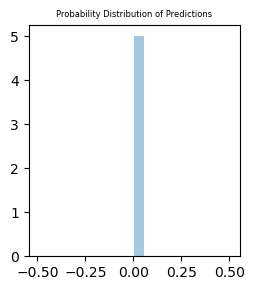

In [ ]:
### Prepare the test data
test_num_features = test_df.drop(['Id', 'EJ', 'BQ', 'EL'], axis=1)
test_cat_features = test_df['EJ']

# Scale the numerical features
num_cols = test_num_features.columns
test_num_features = scaler.transform(test_num_features)
test_num_features = pd.DataFrame(test_num_features, columns=num_cols)

# Convert the categorical features to one-hot encoded features
test_cat_features = pd.get_dummies(test_cat_features)
test_cat_features['B'] = 0

# Concatenate the numerical and categorical features
test_features = np.concatenate((test_num_features, test_cat_features), axis=1)

# Convert the data to TensorFlow tensors
test_features = tf.convert_to_tensor(test_features, dtype=tf.float32)

# Predict the test set results
y_pred = model.predict(test_features)

# Plotting the probability distribution of the predictions
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
sns.distplot(y_pred, bins=20, kde=False)
plt.title('Probability Distribution of Predictions', size=6)
plt.show()

In [ ]:
### Creating a submission file with column names 'Id', 'Class0', 'Class1'
submission_df = pd.DataFrame(columns=['Id', 'class_0', 'class_1'])
submission_df['Id'] = test_df['Id']
submission_df['class_0'] = 1 - y_pred
submission_df['class_1'] = y_pred

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

### Results

1. It was surprising to see Neural Network outperform the decision trees in this problem.
2. A precision of 94% was achieved with the current neural network and data.